In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp drive/MyDrive/helpers.py .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import numpy as np
from torchvision import datasets
from torch import nn
import torchvision.models
import torchvision.transforms as transforms
import multiprocessing
from tqdm import tqdm
from helpers import get_data_loaders
from helpers import seed_all
from helpers import anomaly_detection_display
import pandas as pd

# Ensure repeatibility
seed_all(42)

In [ ]:
# This will get data loaders for the MNIST dataset for the train, validation
# and test dataset
data_loaders = get_data_loaders(batch_size=20)

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


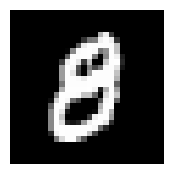

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = next(dataiter)
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig, sub = plt.subplots(figsize = (2,2))
sub.imshow(img, cmap='gray')
_ = sub.axis("off")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        self.encoder = nn.Sequential(
                       nn.Conv2d(1,16,kernel_size=3, stride=1, padding=1),
                       nn.ReLU(),
                       nn.BatchNorm2d(16),
                       nn.MaxPool2d(2,2),
                       nn.Conv2d(16,32,kernel_size=3, stride=1, padding=1),
                       nn.ReLU(),
                       nn.BatchNorm2d(32),
                       nn.MaxPool2d(2,2)
        )

        self.decoder = nn.Sequential(
                       nn.ConvTranspose2d(32,16,kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
                       nn.ReLU(),
                       nn.BatchNorm2d(16),
                       nn.ConvTranspose2d(16,1,kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
                       nn.Sigmoid()
        )

        self.model = nn.Sequential(
            self.encoder,
            self.decoder
        )

    def forward(self, x):

        return self.model(x)


# initialize the NN
model = ConvDenoiser()

In [ ]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# number of epochs to train the model
n_epochs = 20

# for adding noise to images
noise_factor=0.5

for epoch in range(1, n_epochs+1):

    if torch.cuda.is_available():
        model = model.cuda()

    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data in tqdm(
        desc="Training",
        total=len(data_loaders['train']),
        iterable=data_loaders['train'],
        ncols=80
    ):
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data

        if torch.cuda.is_available():
            images = images.cuda()

        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.rand_like(images)
        # Clip the images to be between 0 and 1
        noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)

        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(images, outputs)

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)

    # Validation
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(desc="Validating", total=len(data_loaders['valid']), iterable=data_loaders['valid'],
        ncols=80):
            # _ stands in for labels, here
            # no need to flatten images
            images, _ = data

            if torch.cuda.is_available():
                images = images.cuda()

            ## add random noise to the input images
            noisy_imgs = images + noise_factor * torch.rand_like(images)
            # Clip the images to be between 0 and 1
            noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)

            ## forward pass: compute predicted outputs by passing *noisy* images to the model
            outputs = model(noisy_imgs)
            # calculate the loss
            # the "target" is still the original, not-noisy images
            loss = criterion(outputs, images)

            # update running training loss
            val_loss += loss.item()*images.size(0)

    # print avg training statistics
    train_loss /= len(data_loaders['train'].dataset)
    val_loss /= len(data_loaders['valid'].dataset)
    print("Epoch: {} \tTraining Loss: {:.6f}\tValid Loss: {:.6f}".format(epoch, train_loss, val_loss))

Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 193.64it/s]


Epoch: 1 	Training Loss: 0.010613	Valid Loss: 0.004038


Validating: 100%|████████████████████████████| 600/600 [00:02<00:00, 238.03it/s]


Epoch: 2 	Training Loss: 0.003706	Valid Loss: 0.003461


Validating: 100%|████████████████████████████| 600/600 [00:02<00:00, 228.34it/s]


Epoch: 3 	Training Loss: 0.003384	Valid Loss: 0.003239


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 153.22it/s]


Epoch: 4 	Training Loss: 0.003193	Valid Loss: 0.003127


Validating: 100%|████████████████████████████| 600/600 [00:02<00:00, 227.87it/s]


Epoch: 5 	Training Loss: 0.003079	Valid Loss: 0.002995


Validating: 100%|████████████████████████████| 600/600 [00:02<00:00, 230.95it/s]


Epoch: 6 	Training Loss: 0.003008	Valid Loss: 0.002965


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 183.34it/s]


Epoch: 7 	Training Loss: 0.002953	Valid Loss: 0.002895


Validating: 100%|████████████████████████████| 600/600 [00:02<00:00, 226.65it/s]


Epoch: 8 	Training Loss: 0.002903	Valid Loss: 0.002860


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 182.64it/s]


Epoch: 9 	Training Loss: 0.002874	Valid Loss: 0.002831


Validating: 100%|████████████████████████████| 600/600 [00:02<00:00, 232.86it/s]


Epoch: 10 	Training Loss: 0.002845	Valid Loss: 0.002835


Validating: 100%|████████████████████████████| 600/600 [00:02<00:00, 225.18it/s]


Epoch: 11 	Training Loss: 0.002827	Valid Loss: 0.002799


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 161.64it/s]


Epoch: 12 	Training Loss: 0.002811	Valid Loss: 0.002789


Validating: 100%|████████████████████████████| 600/600 [00:02<00:00, 222.26it/s]


Epoch: 13 	Training Loss: 0.002797	Valid Loss: 0.002773


Validating: 100%|████████████████████████████| 600/600 [00:02<00:00, 220.28it/s]


Epoch: 14 	Training Loss: 0.002787	Valid Loss: 0.002754


Validating: 100%|████████████████████████████| 600/600 [00:02<00:00, 210.21it/s]


Epoch: 15 	Training Loss: 0.002770	Valid Loss: 0.002764


Validating: 100%|████████████████████████████| 600/600 [00:02<00:00, 222.25it/s]


Epoch: 16 	Training Loss: 0.002765	Valid Loss: 0.002784


Validating: 100%|████████████████████████████| 600/600 [00:04<00:00, 148.80it/s]


Epoch: 17 	Training Loss: 0.002757	Valid Loss: 0.002713


Validating: 100%|████████████████████████████| 600/600 [00:02<00:00, 211.86it/s]


Epoch: 18 	Training Loss: 0.002743	Valid Loss: 0.002737


Validating: 100%|████████████████████████████| 600/600 [00:03<00:00, 194.46it/s]


Epoch: 19 	Training Loss: 0.002735	Valid Loss: 0.002726


Validating: 100%|████████████████████████████| 600/600 [00:02<00:00, 223.95it/s]

Epoch: 20 	Training Loss: 0.002731	Valid Loss: 0.002726


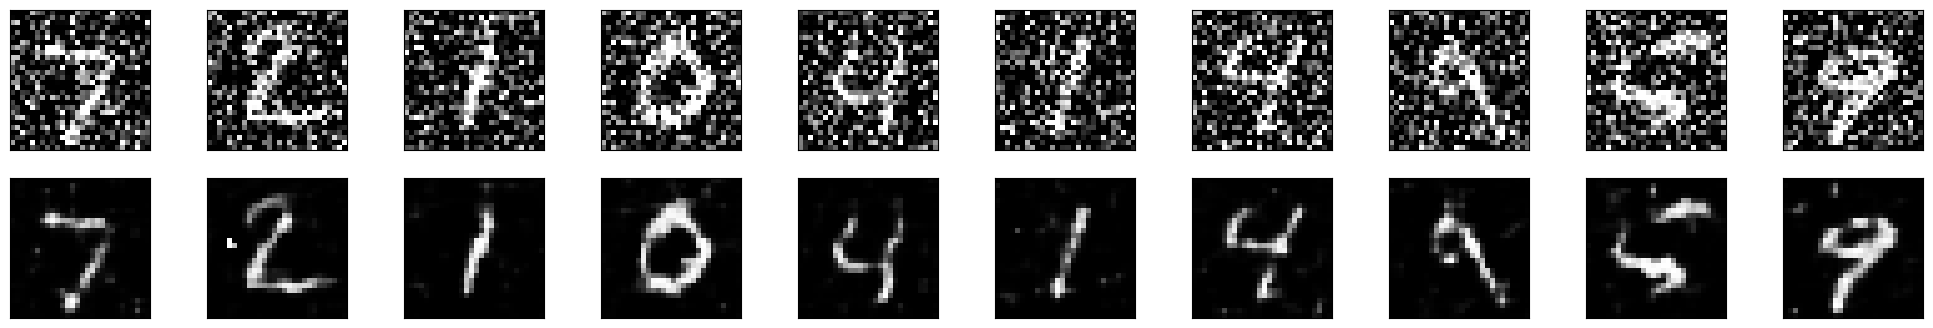

In [ ]:
# obtain one batch of test images
dataiter = iter(data_loaders['test'])
images, labels = next(dataiter)

# add noise to the test images
noisy_imgs = images + 0.5 * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs.cuda())
# prep images for display
noisy_imgs = noisy_imgs.numpy()

# output is resized into a batch of iages
output = output.view(20, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)